In [1]:
from edc import print_info
print_info("sh-data-access")


***Notebook Title***  
Sentinel Hub data access using xcube

***Notebook Description***  
Euro Data Cube Sentinel Hub - data access


***Notebook Dependencies***  
This notebook requires an active subscription to:
* EDC Sentinel Hub


In [2]:
from edc import check_compatibility
check_compatibility("user-2022.07-00", dependencies=["SH"])



---------

The following environment variables are available:

* `SH_CLIENT_ID`, `SH_INSTANCE_ID`, `SH_CLIENT_NAME`, `SH_CLIENT_SECRET`


## EDC Sentinel Hub - data access using xcube

This notebook shows the various ways to open data cubes from Sentinel Hub (SH) for a given time range, region, and spatial resolution:

1. A **temporarily regular Sentinel-2 cube** with aggregated observations that fall into equal-size time periods;
2. A **NDVI time series**
3. A custom collection (**CORINE**)

In [3]:
# xcube_sh imports
from xcube_sh.cube import open_cube
from xcube_sh.config import CubeConfig
from xcube_sh.observers import Observers
from xcube_sh.sentinelhub import SentinelHub
from xcube_sh.viewer import ViewerServer

# xcube imports
from xcube.core.maskset import MaskSet
from xcube.core.geom import mask_dataset_by_geometry
from xcube.core.geom import clip_dataset_by_geometry

# Various utilities
import json
import matplotlib
import pandas as pd
import numpy as np
import xarray as xr
import shapely.geometry
import IPython.display
import zarr
from io import StringIO

In [4]:
%matplotlib inline

In [5]:
# Oslo
x1 = 10.5  # degree
y1 = 59.85  # degree
x2 = 11.25  # degree
y2 = 60.05  # degree

bbox = x1, y1, x2, y2

Visualize the bounding box.

In [6]:
IPython.display.GeoJSON(shapely.geometry.box(*bbox).__geo_interface__)

<IPython.display.GeoJSON object>

Later in this NB we are going to compute some indexes from bands atmospherically corrected bands B04, B05, B06, B11 of Sentinel-2 (S2L2A)
Our time range covers two and a half month of last year's summer: 2018-05-14 to 2018-07-31

The desired resolution is roughly 20 meters per pixel:

In [7]:
spatial_res = 0.00018   # = 20.038 meters in degree>

## Example 1: Visualizing a band
Sentinel-2 L2A with aggregated observations that fall into equal-size `time_period` of 2 days:

In [8]:
cube_config = CubeConfig(dataset_name='S2L2A',
                         band_names=['B04', 'B05', 'B08', 'B11', 'SCL', 'CLD'],
                         tile_size=[512, 512],
                         bbox=bbox,
                         spatial_res=spatial_res,
                         time_range=['2018-05-14', '2018-07-31'],
                         time_period='2D')

We define a `request_collector` as an observer for SH requests made, so we can show SH usage stats. This is a developer tool, useful for demonstration purposes too. **Otherwise, this is not needed.**

In [9]:
request_collector = Observers.request_collector()

Open a data cube:

In [10]:
cube = open_cube(cube_config, observer=request_collector)
cube

<xarray.Dataset>
Dimensions:    (time: 40, lat: 1536, lon: 4608, bnds: 2)
Coordinates:
  * lat        (lat) float64 60.13 60.13 60.13 60.13 ... 59.85 59.85 59.85 59.85
  * lon        (lon) float64 10.5 10.5 10.5 10.5 ... 11.33 11.33 11.33 11.33
  * time       (time) datetime64[ns] 2018-05-15 2018-05-17 ... 2018-08-01
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(40, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B05        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B08        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B11        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    CLD        (time, lat, lon) uint8 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    SCL        (time, lat, lon) uint8 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
Attributes: (12/13)
    Conventions:               CF-1.7
    title:                     S2L2A Data Cube Subset
    history:                   [{'program': 'xcube_sh.chunkstore.SentinelHubC...
    date_created:              2022-10-11T08:17:37.011630
    time_coverage_start:       2018-05-14T00:00:00+00:00
    time_coverage_end:         2018-08-02T00:00:00+00:00
    ...                        ...
    time_coverage_resolution:  P2DT0H0M0S
    geospatial_lon_min:        10.5
    geospatial_lat_min:        59.85
    geospatial_lon_max:        11.32944
    geospatial_lat_max:        60.12648
    processing_level:          L2A

No requests have been made yet. Requests are made only if data is actually required.

In [11]:
request_collector.stats

Note, the cube's time coordinates are monotonically increasing and the distance between two time steps is varying:

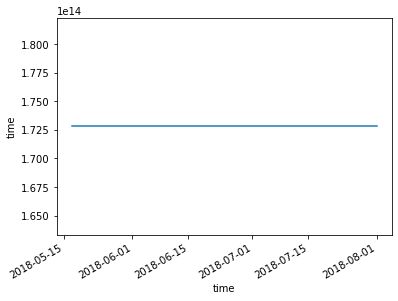

In [12]:
cube.time.diff(dim='time').plot.line()

In [13]:
cube.B04

,Array,Chunk
Bytes,1.05 GiB,1.00 MiB
Shape,"(40, 1536, 4608)","(1, 512, 512)"
Count,1081 Tasks,1080 Chunks
Type,float32,numpy.ndarray


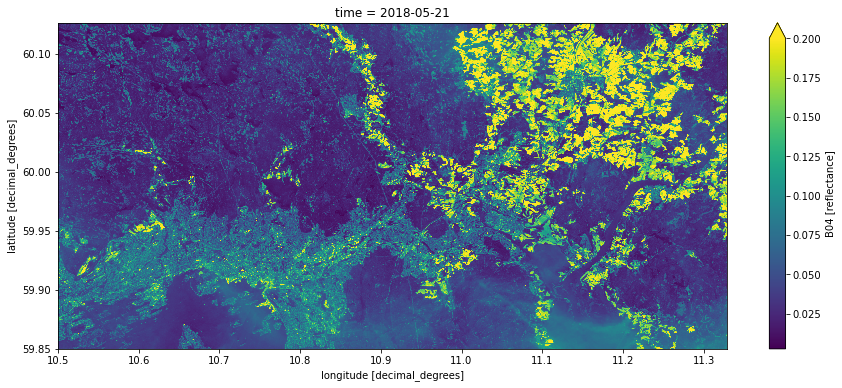

In [14]:
cube.B04.isel(time=3).plot(figsize=[15,6], vmax=0.2);

Now SentinelHub data requests have been made

In [15]:
request_collector.stats

Number of requests:,27
Request duration min:,296.63 ms
Request duration max:,775.49 ms
Request duration median:,400.92 ms
Request duration mean:,444.49 ms
Request duration std:,130.55 ms


## Example 2: Visualizing a NDVI time series

In [16]:
cube.SCL

,Array,Chunk
Bytes,270.00 MiB,256.00 kiB
Shape,"(40, 1536, 4608)","(1, 512, 512)"
Count,1081 Tasks,1080 Chunks
Type,uint8,numpy.ndarray


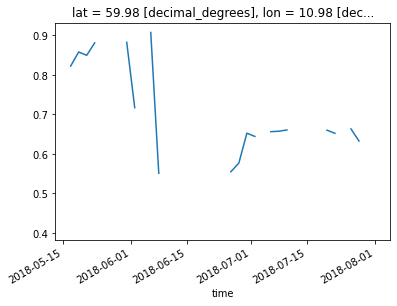

In [17]:
masked = cube.where(np.logical_or(cube.SCL < 8, cube.SCL > 10)) # clouds
ndvi = (masked.B08 - masked.B04)/(masked.B08 + masked.B04)
# agricultural area near Oslo
ndvi.sel(lat=59.979800, lon=10.982700, method="nearest").plot.line()

## Example 3: CORINE

The [CORINE collection](https://collections.eurodatacube.com/corine-land-cover/) is available on the CREODIAS deployment of Sentinel Hub.


[Corine land cover nomenclature](https://land.copernicus.eu/user-corner/technical-library/corine-land-cover-nomenclature-guidelines/html/index.html)

In [18]:
cube_config = CubeConfig(collection_id = "cbdba844-f86d-41dc-95ad-b3f7f12535e9",
                         tile_size=[512, 512],
                         bbox=bbox,
                         spatial_res=spatial_res*5, # 100m
                         time_range=["1990-01-01", "2018-12-31"],
                         time_period=None
)
corine = open_cube(cube_config, api_url="https://creodias.sentinel-hub.com")  # 

/opt/conda/envs/edc-default-2022.07-00/lib/python3.9/site-packages/pandas/core/tools/timedeltas.py:148: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  return _coerce_scalar_to_timedelta_type(arg, unit=unit, errors=errors)


In [19]:
corine.CLC

<xarray.DataArray 'CLC' (time: 5, lat: 222, lon: 1024)>
dask.array<open_dataset-de45f3515e2b5218576176d3cf69a6e0CLC, shape=(5, 222, 1024), dtype=uint8, chunksize=(1, 222, 512), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 60.05 60.05 60.05 60.05 ... 59.85 59.85 59.85 59.85
  * lon      (lon) float64 10.5 10.5 10.5 10.5 10.5 ... 11.42 11.42 11.42 11.42
  * time     (time) datetime64[ns] 1990-01-01 2000-01-01 ... 2018-01-01

In [20]:
df = pd.read_csv(StringIO("""
value,color_code,label
1,#e6004d,111 - Continuous urban fabric
2,#ff0000,112 - Discontinuous urban fabric
3,#cc4df2,121 - Industrial or commercial units
4,#cc0000,122 - Road and rail networks and associated land
5,#e6cccc,123 - Port areas
6,#e6cce6,124 - Airports
7,#a600cc,131 - Mineral extraction sites
8,#a64d00,132 - Dump sites
9,#ff4dff,133 - Construction sites
10,#ffa6ff,141 - Green urban areas
11,#ffe6ff,142 - Sport and leisure facilities
12,#ffffa8,211 - Non-irrigated arable land
13,#ffff00,212 - Permanently irrigated land
14,#e6e600,213 - Rice fields
15,#e68000,221 - Vineyards
16,#f2a64d,222 - Fruit trees and berry plantations
17,#e6a600,223 - Olive groves
18,#e6e64d,231 - Pastures
19,#ffe6a6,241 - Annual crops associated with permanent crops
20,#ffe64d,242 - Complex cultivation patterns
21,#e6cc4d,243 - Land principally occupied by agriculture with significant areas of natural vegetation
22,#f2cca6,244 - Agro-forestry areas
23,#80ff00,311 - Broad-leaved forest
24,#00a600,312 - Coniferous forest
25,#4dff00,313 - Mixed forest
26,#ccf24d,321 - Natural grasslands
27,#a6ff80,322 - Moors and heathland
28,#a6e64d,323 - Sclerophyllous vegetation
29,#a6f200,324 - Transitional woodland-shrub
30,#e6e6e6,331 - Beaches - dunes - sands
31,#cccccc,332 - Bare rocks
32,#ccffcc,333 - Sparsely vegetated areas
33,#000000,334 - Burnt areas
34,#a6e6cc,335 - Glaciers and perpetual snow
35,#a6a6ff,411 - Inland marshes
36,#4d4dff,412 - Peat bogs
37,#ccccff,421 - Salt marshes
38,#e6e6ff,422 - Salines
39,#a6a6e6,423 - Intertidal flats
40,#00ccf2,511 - Water courses
41,#80f2e6,512 - Water bodies
42,#00ffa6,521 - Coastal lagoons
43,#a6ffe6,522 - Estuaries
44,#e6f2ff,523 - Sea and ocean
48,#ffffff,999 - NODATA
"""))
cmap, norm = matplotlib.colors.from_levels_and_colors(df.value.values, df.color_code.values, extend="max")

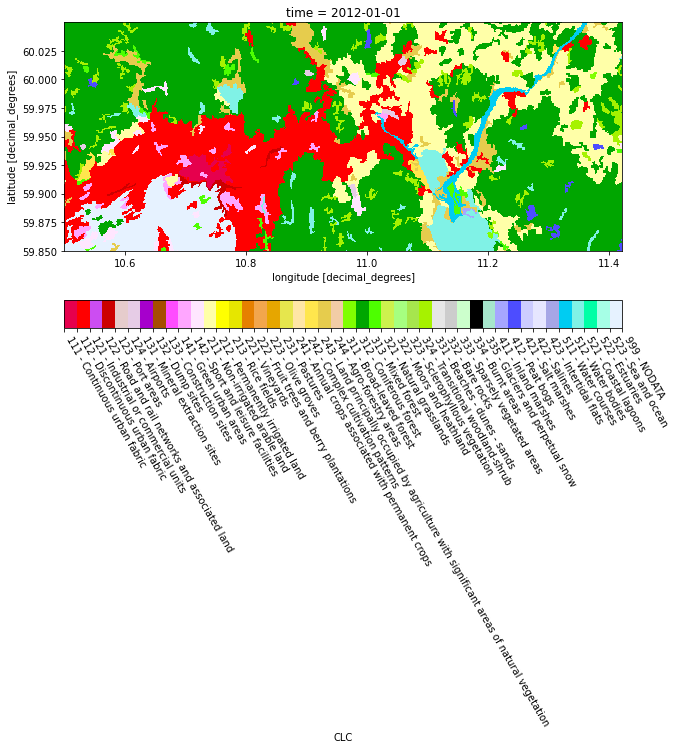

In [21]:
imgplot = corine.CLC.isel(time=3).plot.imshow(
    figsize=[10,6], cbar_kwargs={"orientation":"horizontal"}, vmin=df.value.min(), vmax=df.value.max(), norm=norm
);
imgplot.set_cmap(cmap)
imgplot.colorbar.set_ticks(df.value, labels = df.label, horizontalalignment="left", rotation=300)

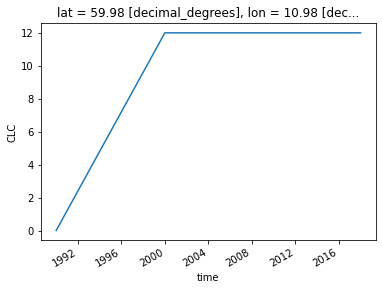

In [22]:
corine.CLC.sel(lat=59.979800, lon=10.982700, method="nearest").plot.line()